- https://realpython.com/generative-adversarial-networks/
- https://proglib.io/p/generativno-sostyazatelnaya-neyroset-vasha-pervaya-gan-model-na-pytorch-2020-08-11

In [1]:
import torch
from torch import nn

In [2]:
import math
import matplotlib.pyplot as plt

In [3]:
import torchvision
import torchvision.transforms as transforms

In [4]:
torch.manual_seed(111)

In [5]:
torch.__version__

'2.4.0+cu118'

In [6]:
device = None

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [7]:
device

device(type='cuda')

In [8]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [9]:
transform

Compose(
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)

In [10]:
train_set = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=transform)

In [11]:
latent_size = 32

In [12]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

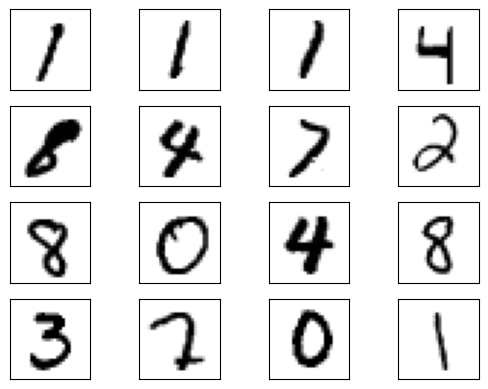

In [13]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [14]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
    
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [15]:
discriminator = Discriminator().to(device=device)

In [16]:
class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(latent_size, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

In [17]:
generator = Generator().to(device=device)

In [18]:
lr = 0.0001

In [19]:
num_epochs = 100

In [20]:
loss_function = nn.BCELoss()

In [21]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)

In [22]:
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [23]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        batch_size = len(real_samples)
        
        # the real digit samples with label "1"
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device)

        # random input vectors for the generator
        latent_space_samples = torch.randn((batch_size, latent_size)).to(device=device)

        # generated samples with label "0"
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)

        # combine the real samples and the generated samples into the single set
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # train the disriminator on the combined samples
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # random input vectors for the generator
        latent_space_samples = torch.randn((batch_size, latent_size)).to(device=device)

        # train the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

    # show loss
    print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
    print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.044601984322071075
Epoch: 0 Loss G.: 4.046700477600098
Epoch: 1 Loss D.: 0.010590732097625732
Epoch: 1 Loss G.: 6.073422431945801
Epoch: 2 Loss D.: 0.0002862465917132795
Epoch: 2 Loss G.: 10.279151916503906
Epoch: 3 Loss D.: 0.006334478966891766
Epoch: 3 Loss G.: 6.290925025939941
Epoch: 4 Loss D.: 0.023767413571476936
Epoch: 4 Loss G.: 6.77415657043457
Epoch: 5 Loss D.: 9.553070412948728e-05
Epoch: 5 Loss G.: 11.74053955078125
Epoch: 6 Loss D.: 0.003407228272408247
Epoch: 6 Loss G.: 7.356197357177734
Epoch: 7 Loss D.: 0.006394344847649336
Epoch: 7 Loss G.: 7.553951263427734
Epoch: 8 Loss D.: 0.0006726770079694688
Epoch: 8 Loss G.: 8.149861335754395
Epoch: 9 Loss D.: 0.23033826053142548
Epoch: 9 Loss G.: 6.447664737701416
Epoch: 10 Loss D.: 0.09765687584877014
Epoch: 10 Loss G.: 4.635580539703369
Epoch: 11 Loss D.: 0.05796254798769951
Epoch: 11 Loss G.: 3.9593944549560547
Epoch: 12 Loss D.: 0.09516093134880066
Epoch: 12 Loss G.: 3.309509515762329
Epoch: 13 Loss D.: 

In [24]:
latent_space_samples = torch.randn(16, latent_size).to(device=device)

In [25]:
generated_samples = generator(latent_space_samples)

In [26]:
generated_samples = generated_samples.cpu().detach()

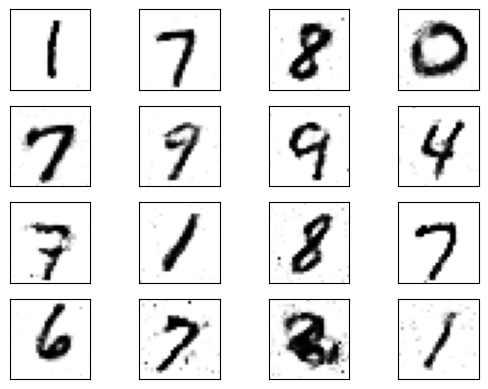

In [27]:
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])